# Solucion # 2

Autor: Ernesto Girón E. 

## Detección de intrusos en redes

Estos datos fueron usados para la edición de 1999 del KDD cup. Los datos fueron generados por Lincoln Labs: _Nueve semanas de registro de paquetes TCP fueron recolectadas para una red LAN de una oficina de las fuerzas aéreas de USA._ Durante el uso de la LAN, _varios ataques_ fueron ejecutados por el personal. El paquete crudo fue agregado junto con la información de la conexión. 

Para cada registro, algunas características extra fueron derivadas, basados en conocimiento del dominio sobre ataques a redes; _hay 38 tipos diferentes de ataques, pertenecientes a 4 categorías principales_. Algunos tipos de ataque aparecen solo en los datos de prueba(test data), y las frecuencias de los tipo de ataque en los conjuntos de entrenamiento y prueba no son las mismas(para hacerlo más realista). Información adicional sobre los datos puede ser encontrada en (http://kdd.ics.uci.edu/databases/kddcup99/task.html) y los resumenes de los resultados de la competencia KDD cup (http://cseweb.ucsd.edu/~elkan/clresults.html). En la última página también se indica que hay una matriz de costo asociada con las equivocaciones.  El ganador de la competencia usó árboles de decisión C5 en combinación con boosting y bagging.

**Referencias**:
- PNrule: _A New Framework for Learning Classifier Models in Data Mining (A Case-Study in Network Intrusion Detection) (2000) by R. Agarwal and M. V. Joshi_. This paper proposes a new, very simple rule learning algorithm, and tests it on the network intrusion dataset. In the first stage, rules are learned to identify the target class, and then in the second stage, rules are learned to identify cases that were incorrectly classified as positive according to the first rules.

## Pasos a llevar a cabo en la solución 2

- Cargar las librerías a utilizar
- Cargar los datos completos ya procesados a un dataframe
- Visualización rápida de los datos
- Separando el conjunto de datos de entrenamiento y de validación
- Selección de algoritmos y métodos usados en la Solución 1
- Resumen de los métodos utilizados
- Comparación de resultados con el ganador del KDDCup

En este notebook solo nos dedicaremos a la implementación de algoritmos, modelos y métodos utilizando el juego de datos completo y depurado. 

## Cargar las librerías a utilizar

In [1]:
%matplotlib inline

from time import time
from itertools import product
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import graphviz
from sklearn import metrics
from sklearn.metrics import r2_score, make_scorer, accuracy_score, confusion_matrix
from sklearn.utils import resample
from sklearn.svm import SVC
from sklearn.cluster import KMeans
from sklearn.neighbors import KNeighborsClassifier
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale, StandardScaler
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import SelectFromModel
from sklearn.feature_selection import chi2
from sklearn.linear_model import Ridge
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.tree import export_graphviz
from treeinterpreter import treeinterpreter as ti
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier
from xgboost import plot_importance

from IPython.display import display, HTML

# Modulo personal para hacer mas claro el ejercicio
from egironML import EDA
from egironML import run_kfold

plt.style.use('seaborn-white')

## Cargar los datos

Los datos que se cargan a continuación ya fueron procesados para ser utilizados eficientemente en los diferentes algoritmos y/o programas de ML. Los pasos que se llevaron a cabo pueden ser vistos en [Solución 2 - Depurar-dataset-completo](Solucion%202%20-%20Depurar%20dataset%20completo.ipynb#Solucion-2---Depurar-dataset-completo)


In [2]:
ataques_train = pd.read_csv('data/kddcup.data_clean_train.csv', sep=',', decimal='.')
ataques_test = pd.read_csv('data/kddcup.data_clean_test.csv', sep=',', decimal='.')
print("Cantidad de observaciones %i con %i variables (Entrenamiento)" %(ataques_train.shape[0],ataques_train.shape[1]))
print("Cantidad de observaciones %i con %i variables (Validación)" %(ataques_test.shape[0],ataques_test.shape[1]))

Cantidad de observaciones 752494 con 11 variables (Entrenamiento)
Cantidad de observaciones 322498 con 11 variables (Validación)


### Otra forma de cargar los datos es utilizando el dataset de scikit-learn

Utilizando [este enlace](http://scikit-learn.org/stable/modules/generated/sklearn.datasets.fetch_kddcup99.html#sklearn.datasets.fetch_kddcup99) se pueden obtener los mismo datos ya preparados para realizar los diferentes análisis de mineria de datos y aprendizaje automático.

``` python
from sklearn import datasets
# import some data to play with
kddcup99 = datasets.fetch_kddcup99()
X = kddcup99.data
y = kddcup99.target
```

## Visualizar los datos

In [3]:
EDA.printall(ataques_train, 15)

,same_srv_rate,dst_host_srv_serror_rate,flag_S0,dst_host_serror_rate,srv_serror_rate,flag_SF,serror_rate,service_private,dst_host_same_srv_rate,count,attack_category
0,1.00,0.00,0,0.0,0.0,1,0.0,0,1.00,1,probe
1,1.00,0.00,0,0.0,0.0,0,0.0,0,1.00,1,normal
2,1.00,0.00,0,0.0,0.0,0,0.0,1,0.00,1,probe
3,0.50,0.00,0,0.0,0.0,1,0.0,0,0.65,2,normal
4,1.00,0.01,0,0.0,0.0,1,0.0,0,1.00,2,normal
5,1.00,0.00,0,0.0,0.0,1,0.0,0,0.08,2,normal
6,0.04,1.00,1,1.0,1.0,0,1.0,1,0.05,213,dos
...,...,...,...,...,...,...,...,...,...,...,...
752487,1.00,0.00,0,0.0,0.0,1,0.0,0,1.00,17,normal
752488,0.50,0.00,0,0.0,0.0,1,0.0,0,0.60,2,normal


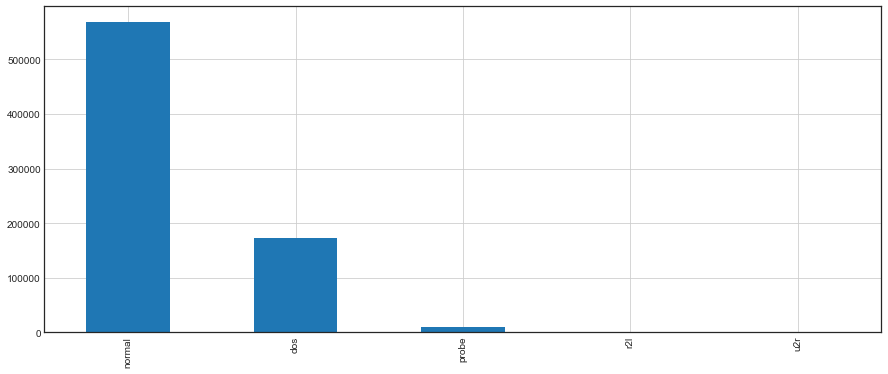

In [4]:
# Veamos la distribucción de los ataques
ataques_train.attack_category.value_counts().plot(kind='bar', grid=True, figsize=(15, 6))

In [5]:
ataques_train.attack_category.value_counts()

normal    568818
dos       173290
probe       9631
r2l          720
u2r           35
Name: attack_category, dtype: int64

In [7]:
corr = ataques_train.corr()
corr.head(40)

,same_srv_rate,dst_host_srv_serror_rate,flag_S0,dst_host_serror_rate,srv_serror_rate,flag_SF,serror_rate,service_private,dst_host_same_srv_rate,count
same_srv_rate,1.000000,-0.857361,-0.857416,-0.854746,-0.855662,0.875628,-0.855435,-0.798974,0.822824,-0.839728
dst_host_srv_serror_rate,-0.857361,1.000000,0.996945,0.995208,0.997438,-0.798643,0.995120,0.728879,-0.709601,0.734496
flag_S0,-0.857416,0.996945,1.000000,0.993648,0.996796,-0.799382,0.994746,0.727246,-0.707233,0.734623
dst_host_serror_rate,-0.854746,0.995208,0.993648,1.000000,0.993723,-0.796541,0.995738,0.728176,-0.710481,0.728736
srv_serror_rate,-0.855662,0.997438,0.996796,0.993723,1.000000,-0.799982,0.996973,0.727520,-0.706967,0.732749
flag_SF,0.875628,-0.798643,-0.799382,-0.796541,-0.799982,1.000000,-0.799754,-0.742058,0.712908,-0.744558
serror_rate,-0.855435,0.995120,0.994746,0.995738,0.996973,-0.799754,1.000000,0.728622,-0.706946,0.728841
service_private,-0.798974,0.728879,0.727246,0.728176,0.727520,-0.742058,0.728622,1.000000,-0.672443,0.641564
dst_host_same_srv_rate,0.822824,-0.709601,-0.707233,-0.710481,-0.706967,0.712908,-0.706946,-0.672443,1.000000,-0.662356
count,-0.839728,0.734496,0.734623,0.728736,0.732749,-0.744558,0.728841,0.641564,-0.662356,1.000000


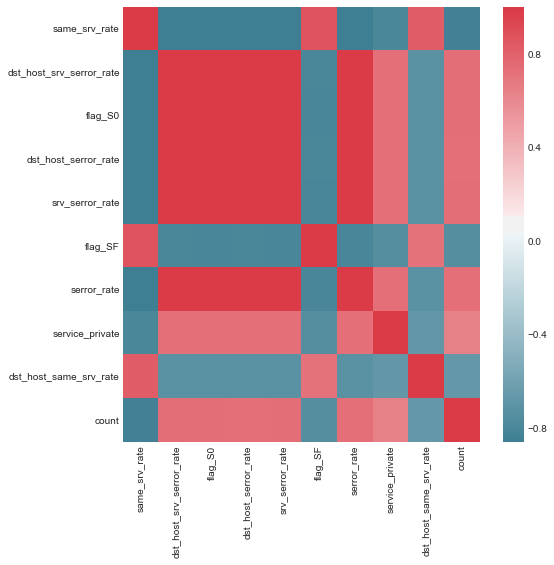

In [11]:
f, ax = plt.subplots(figsize=(8, 8))
sns.heatmap(corr, mask=np.zeros_like(corr, dtype=np.bool), cmap=sns.diverging_palette(220, 10, as_cmap=True),
            square=False, ax=ax)

In [15]:
# Esta comentado por que toma mucho tiempo producir el gráfico
#datatograph = ataques_train[['same_srv_rate', 'dst_host_srv_serror_rate', 'flag_S0', 'dst_host_serror_rate', 'srv_serror_rate', 'flag_SF', 'serror_rate', 'service_private', 'dst_host_same_srv_rate', 'count']]
# pd.plotting.scatter_matrix(ataques_train, alpha = 0.3, figsize = (14,14), diagonal = 'kde')

![scatterplot](./data/scatterplot.png)

## Selección de algoritmos y métodos

In [ ]:
# Definimos los datos en entrenamiento y validación
X_train = ataques_train.drop(['attack_category'], axis=1)
y_train = ataques_train.attack_category.copy()

X_test = ataques_test.drop(['attack_category'], axis=1)
y_test = ataques_test.attack_category.copy()

In [20]:
X_train.columns

Index(['same_srv_rate', 'dst_host_srv_serror_rate', 'flag_S0',
       'dst_host_serror_rate', 'srv_serror_rate', 'flag_SF', 'serror_rate',
       'service_private', 'dst_host_same_srv_rate', 'count'],
      dtype='object')

In [23]:
# Cargamos los datos de validación del 10% de la competencia 
ataques_10prec_test = pd.read_csv('data/data_10per_test_preprocessed.csv', sep=',', decimal='.')
X_test_10perc = ataques_10prec_test[['same_srv_rate', 'dst_host_srv_serror_rate', 'flag_S0',
       'dst_host_serror_rate', 'srv_serror_rate', 'flag_SF', 'serror_rate',
       'service_private', 'dst_host_same_srv_rate', 'count']]

print(X_test_10perc.shape)
y_test_10perc = ataques_10prec_test[['attack_category']]
print(y_test_10perc.shape)

(311029, 10)
(311029, 1)


### Árbol de decisión

In [17]:
# Árbol de decisión
t0 = time()
# Ajustamos un árbol de clasificación
treeclf = DecisionTreeClassifier(random_state=1)
treeclf.fit(X_train,y_train)
# Verificamos la precisión de nuestro modelo, tanto como los datos de entrenamiento y los de validación
print("Precisión Datos Entranamiento: ",treeclf.score(X_train,y_train))
print("Precisión Datos Validación: ",treeclf.score(X_test,y_test))
print("-"*80)
# Hacemos prediciones sobre los datos de validación
y_pred = treeclf.predict(X_test)
# Calcular y desplegar la matríz de confusión
cnf_matrix = confusion_matrix(y_test, y_pred)
print(cnf_matrix)
print("Tiempo total: %.2fs" % (time() - t0))

Precisión Datos Entranamiento:  0.992572698254
Precisión Datos Validación:  0.991906926555
--------------------------------------------------------------------------------
[[ 73398    536     42      1      0]
 [   100 243830     46     19      1]
 [   124   1468   2636      1      0]
 [     1    254      0     24      0]
 [     0     17      0      0      0]]
Tiempo total: 6.49s


In [25]:
t0 = time()
print("Precisión Datos Validación 10%: ",treeclf.score(X_test_10perc,y_test_10perc))
y_pred = treeclf.predict(X_test_10perc)
# Calcular y desplegar la matríz de confusión
cnf_matrix = confusion_matrix(y_test_10perc, y_pred)
print(cnf_matrix)
print("Tiempo total: %.2fs" % (time() - t0))

Precisión Datos Validación 10%:  0.804690237888
[[188866  33984    448      0      0      0]
 [   710  59530    344      8      1      0]
 [    26    476   1875      0      0      0]
 [     0   5970     12     11      0      0]
 [     0     39      0      0      0      0]
 [   340  17542    721    126      0      0]]
Tiempo total: 1.92s


**La precisión es algo baja teniendo en cuenta que en los datos de entrenamiento del conjunto de datos completo, no existen algunos tipos de ataques que aparecen en la dataset de validación del 10% y que fueron renombrados como desconocidos o "unknown"; adicional a esto los datos estan desbalanceados por lo que los ataques con poca frecuencia no son modelados bien, es necesario corregir la data antes de hacer estos análisis**

## Balanceo de los datos originales

Una forma de hacerlo sería tomar las observaciones del conjunto de datos completo y unirlas con las observaciones de los datos corregidos de validación; esto permitiría incluir las clases faltantes de tipos de ataques y estimar mejor las predicciones aumentando la precisión. Dado que los datos corregidos es lo último que tomaremos para poder validar la precisión de nuestro modelo con la del ganador del concurso, eso no sería lo correcto.

Por otro lado, la otra forma de solucionar este problema es balancear el numero de datos por cada categoría a predecir y utilizar esta nueva muestra de entrenamiento en los análisis.

Ahora bien, procedemos a balancear nuestros datos de muestra o entrenamiento extraidos del conjunto completo de datos.

In [64]:
ataques_train.attack_category.value_counts()

normal    568818
dos       173290
probe       9631
r2l          720
u2r           35
Name: attack_category, dtype: int64

In [72]:
# # Balanceo de los datos de forma manual, para entender un poco de que se trata
# from sklearn.utils import resample
# # Separamos en los datos en las diferentes clases
# df_normal = ataques_train[ataques_train.attack_category=='normal']
# df_dos = ataques_train[ataques_train.attack_category=='dos']
# df_probe = ataques_train[ataques_train.attack_category=='probe']
# df_r2l = ataques_train[ataques_train.attack_category=='r2l']
# df_u2r = ataques_train[ataques_train.attack_category=='u2r']
# #df_unknown = ataques_train[ataques_train.attack_category=='unknown']

# # Upsample - remuestreo por encima, duplicando datos en las clases menores
# # Esto termina con mas datos que la muestra original, afectando el rendimiento 
# # en algunos algoritmos si la muestra es grande
# num_obs = df_normal.shape[0]
# df_dos_upsampled = resample(df_dos, replace=True, n_samples=num_obs, random_state=123)
# df_probe_upsampled = resample(df_probe, replace=True, n_samples=num_obs, random_state=123)
# df_r2l_upsampled = resample(df_r2l, replace=True, n_samples=num_obs, random_state=123)
# df_u2r_upsampled = resample(df_u2r, replace=True, n_samples=num_obs, random_state=123)

# # Down-sample - Termina con menos datos que la muestra original
# num_obs = df_u2r.shape[0]
# df_normal_downsampled = resample(df_normal, replace=False, n_samples=num_obs, random_state=123)
# df_dos_downsampled = resample(df_dos, replace=False, n_samples=num_obs, random_state=123)
# df_probe_downsampled = resample(df_probe, replace=False, n_samples=num_obs, random_state=123)
# df_r2l_downsampled = resample(df_r2l, replace=False, n_samples=num_obs, random_state=123)
# # df_u2r_downsampled = resample(df_u2r, replace=False, n_samples=num_obs, random_state=123)


# # Combinar las clases con los nuevos datos remuestreados
# df_upsampled = pd.concat([df_normal, df_dos_upsampled, df_probe_upsampled, df_r2l_upsampled, df_u2r_upsampled])
#  # Combinar las clases con los nuevos datos remuestreados
# df_downsampled = pd.concat([df_normal_downsampled, df_dos_downsampled, df_probe_downsampled, df_r2l_downsampled, df_u2r])
 
    
# # Desplegar las cantidades de los nuevos datos
# print(df_upsampled.attack_category.value_counts())
# # Desplegar las cantidades de los nuevos datos
# df_downsampled.attack_category.value_counts()

In [83]:
# Forma más eficiente y automatica
# df2 = EDA.balanced_spl_by(ataques_train, 'attack_category', True) # True -> down sample, False -> up sample

attack_category_group = ataques_train.groupby('attack_category')
num_obs = attack_category_group.size().max() # up-sampling
# num_obs = attack_category_group.size().min() # down-sampling
# attack_category_group = attack_category_group.apply(lambda x: x.sample(num_obs, replace=False)).reset_index(drop=True)
attack_category_group = attack_category_group.apply(lambda x: x.sample(num_obs, replace=True)).reset_index(drop=True)
attack_category_group.attack_category.value_counts()

normal    568818
r2l       568818
dos       568818
u2r       568818
probe     568818
Name: attack_category, dtype: int64

In [85]:
attack_category_group.shape

(2844090, 11)

In [86]:
# Árbol de decisión
t0 = time()

y = attack_category_group.attack_category.copy()
X = attack_category_group.drop('attack_category', axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=35)

# Ajustamos un árbol de clasificación
treeclf = DecisionTreeClassifier(random_state=1)
treeclf.fit(X_train,y_train)
# Verificamos la precisión de nuestro modelo, tanto como los datos de entrenamiento y los de validación
print("Precisión Datos Entranamiento: ",treeclf.score(X_train,y_train))
print("Precisión Datos Validación: ",treeclf.score(X_test,y_test))
print("-"*80)
# Hacemos prediciones sobre los datos de validación
y_pred = treeclf.predict(X_test)
# Calcular y desplegar la matríz de confusión
cnf_matrix = confusion_matrix(y_test, y_pred)
print(cnf_matrix)
print("Tiempo total: %.2fs" % (time() - t0))
t0 = time()
print("Precisión Datos Validación 10%: ",treeclf.score(X_test_10perc,y_test_10perc))
y_pred = treeclf.predict(X_test_10perc)
# Calcular y desplegar la matríz de confusión
cnf_matrix = confusion_matrix(y_test_10perc, y_pred)
print(cnf_matrix)
print("Tiempo total: %.2fs" % (time() - t0))

Precisión Datos Entranamiento:  0.815216818033
Precisión Datos Validación:  0.815239672444
--------------------------------------------------------------------------------
[[112715    539    626     83     52]
 [   154  90073    288  10898  12033]
 [    26    774  77992    305  34539]
 [     0   1580      0  78546  33461]
 [     0   3305      0   6432 104397]]
Tiempo total: 23.75s
Precisión Datos Validación 10%:  0.756688283086
[[189790  30916   2469     49     74      0]
 [   863  42434   7411   4322   5563      0]
 [    84    129   1856      4    304      0]
 [     2   3756     19   1263    953      0]
 [     0     20      0     10      9      0]
 [   259   9503   8595    237    135      0]]
Tiempo total: 1.95s


Como puede observarse la precisión es mas baja que la anterior de (80.47%) pero clasifica mejor los datos de las frecuencias bajas de _probe, r2l y u2r_. De igual modo podriamos bajar un poco las frecuencias de los valores altos de la clase _normal y dos_ y probar con estos nuevos conjuntos de datos.

In [87]:
# Balanceo de los datos de forma manual, para entender un poco de que se trata
from sklearn.utils import resample
# Separamos en los datos en las diferentes clases
df_normal = ataques_train[ataques_train.attack_category=='normal']
df_dos = ataques_train[ataques_train.attack_category=='dos']
df_probe = ataques_train[ataques_train.attack_category=='probe']
df_r2l = ataques_train[ataques_train.attack_category=='r2l']
df_u2r = ataques_train[ataques_train.attack_category=='u2r']
#df_unknown = ataques_train[ataques_train.attack_category=='unknown']

# Remuestreo tomando solo un conjnto de datos menor en las clases de mayor frecuencia
num_obs = 50000
df_normal_downsampled = resample(df_normal, replace=False, n_samples=num_obs, random_state=123)
df_dos_downsampled = resample(df_dos, replace=False, n_samples=num_obs, random_state=123)
df_probe_upsampled = resample(df_probe, replace=True, n_samples=num_obs, random_state=123)
df_r2l_upsampled = resample(df_r2l, replace=True, n_samples=num_obs, random_state=123)
df_u2r_upsampled = resample(df_u2r, replace=True, n_samples=num_obs, random_state=123)

# Combinar las clases con los nuevos datos remuestreados
df_sampled = pd.concat([df_normal_downsampled, df_dos_downsampled, df_probe_upsampled, df_r2l_upsampled, df_u2r_upsampled])
    
# Desplegar las cantidades de los nuevos datos
print(df_sampled.attack_category.value_counts())

u2r       50000
normal    50000
probe     50000
dos       50000
r2l       50000
Name: attack_category, dtype: int64


In [88]:
# Árbol de decisión
t0 = time()

y = df_sampled.attack_category.copy()
X = df_sampled.drop('attack_category', axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=35)

# Ajustamos un árbol de clasificación
treeclf = DecisionTreeClassifier(random_state=1)
treeclf.fit(X_train,y_train)
# Verificamos la precisión de nuestro modelo, tanto como los datos de entrenamiento y los de validación
print("Precisión Datos Entranamiento: ",treeclf.score(X_train,y_train))
print("Precisión Datos Validación: ",treeclf.score(X_test,y_test))
print("-"*80)
# Hacemos prediciones sobre los datos de validación
y_pred = treeclf.predict(X_test)
# Calcular y desplegar la matríz de confusión
cnf_matrix = confusion_matrix(y_test, y_pred)
print(cnf_matrix)
print("Tiempo total: %.2fs" % (time() - t0))
t0 = time()
print("Precisión Datos Validación 10%: ",treeclf.score(X_test_10perc,y_test_10perc))
y_pred = treeclf.predict(X_test_10perc)
# Calcular y desplegar la matríz de confusión
cnf_matrix = confusion_matrix(y_test_10perc, y_pred)
print(cnf_matrix)
print("Tiempo total: %.2fs" % (time() - t0))

Precisión Datos Entranamiento:  0.813925
Precisión Datos Validación:  0.81108
--------------------------------------------------------------------------------
[[9866   54   74   13    5]
 [  34 7938   40  989 1112]
 [  22   68 6725   35 3077]
 [   0  148    0 6825 2960]
 [   0  302    0  513 9200]]
Tiempo total: 1.37s
Precisión Datos Validación 10%:  0.774426178909
[[195513  25196   2475     40     74      0]
 [   926  42296   7476   4331   5564      0]
 [    94    126   1770     83    304      0]
 [     0   3728     31   1281    953      0]
 [     0     20      0     10      9      0]
 [   586   8976   8796    236    135      0]]
Tiempo total: 1.97s


Como se observa solo mejora un poco la precisión, aunque los procesos son mas eficientes al reducir la dimensionalidad de la muestra.

In [93]:
# Ultima prueba con los datos de las clases normal y dos remuestreadas, dejando el resto igual
# Separamos en los datos en las diferentes clases
df_normal = ataques_train[ataques_train.attack_category=='normal']
df_dos = ataques_train[ataques_train.attack_category=='dos']
df_probe = ataques_train[ataques_train.attack_category=='probe']
df_r2l = ataques_train[ataques_train.attack_category=='r2l']
df_u2r = ataques_train[ataques_train.attack_category=='u2r']
#df_unknown = ataques_train[ataques_train.attack_category=='unknown']

# Remuestreo tomando solo un conjnto de datos menor en las clases de mayor frecuencia
num_obs = 50000
df_normal_downsampled = resample(df_normal, replace=False, n_samples=num_obs, random_state=123)
df_dos_downsampled = resample(df_dos, replace=False, n_samples=num_obs, random_state=123)

# Combinar las clases con los nuevos datos remuestreados
df_sampled = pd.concat([df_normal_downsampled, df_dos_downsampled, df_probe, df_r2l, df_u2r])
    
# Desplegar las cantidades de los nuevos datos
print(df_sampled.attack_category.value_counts())

# Árbol de decisión
t0 = time()

y = df_sampled.attack_category.copy()
X = df_sampled.drop('attack_category', axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=35)

# Ajustamos un árbol de clasificación
treeclf = DecisionTreeClassifier(random_state=1)
treeclf.fit(X_train,y_train)
# Verificamos la precisión de nuestro modelo, tanto como los datos de entrenamiento y los de validación
print("Precisión Datos Entranamiento: ",treeclf.score(X_train,y_train))
print("Precisión Datos Validación: ",treeclf.score(X_test,y_test))
print("-"*80)
# Hacemos prediciones sobre los datos de validación
y_pred = treeclf.predict(X_test)
# Calcular y desplegar la matríz de confusión
cnf_matrix = confusion_matrix(y_test, y_pred)
print(cnf_matrix)
print("Tiempo total: %.2fs" % (time() - t0))
t0 = time()
print("Precisión Datos Validación 10%: ",treeclf.score(X_test_10perc,y_test_10perc))
y_pred = treeclf.predict(X_test_10perc)
# Calcular y desplegar la matríz de confusión
cnf_matrix = confusion_matrix(y_test_10perc, y_pred)
print(cnf_matrix)
print("Tiempo total: %.2fs" % (time() - t0))

normal    50000
dos       50000
probe      9631
r2l         720
u2r          35
Name: attack_category, dtype: int64
Precisión Datos Entranamiento:  0.962551524211
Precisión Datos Validación:  0.957786031343
--------------------------------------------------------------------------------
[[ 9802    67    40     0     1]
 [   28 10003    20     3     1]
 [   48   597  1317     0     0]
 [    0   120     0    24     0]
 [    0     7     0     0     0]]
Tiempo total: 0.71s
Precisión Datos Validación 10%:  0.804638795739
[[196042  26140   1116      0      0      0]
 [   166  52225   8178     23      1      0]
 [    85    335   1957      0      0      0]
 [     0   5928     23     42      0      0]
 [     0     37      1      1      0      0]
 [   355   9294   8890    190      0      0]]
Tiempo total: 2.09s


Se observa que mejora la precisión pero no identifica bien los datos de bajas frecuencias volviendo al problema del inicio.

### Remuestreo o balance de los datos final

In [90]:
# Separamos en los datos en las diferentes clases
df_normal = ataques_train[ataques_train.attack_category=='normal']
df_dos = ataques_train[ataques_train.attack_category=='dos']
df_probe = ataques_train[ataques_train.attack_category=='probe']
df_r2l = ataques_train[ataques_train.attack_category=='r2l']
df_u2r = ataques_train[ataques_train.attack_category=='u2r']
#df_unknown = ataques_train[ataques_train.attack_category=='unknown']

# Remuestreo tomando solo un conjnto de datos menor en las clases de mayor frecuencia
num_obs = 10000
df_normal_downsampled = resample(df_normal, replace=False, n_samples=num_obs, random_state=123)
df_dos_downsampled = resample(df_dos, replace=False, n_samples=num_obs, random_state=123)
df_probe_upsampled = resample(df_probe, replace=True, n_samples=num_obs, random_state=123)
df_r2l_upsampled = resample(df_r2l, replace=True, n_samples=num_obs, random_state=123)
df_u2r_upsampled = resample(df_u2r, replace=True, n_samples=num_obs, random_state=123)

# Combinar las clases con los nuevos datos remuestreados
df_sampled = pd.concat([df_normal_downsampled, df_dos_downsampled, df_probe_upsampled, df_r2l_upsampled, df_u2r_upsampled])
    
# Desplegar las cantidades de los nuevos datos
print(df_sampled.attack_category.value_counts())

# Árbol de decisión
t0 = time()

y = df_sampled.attack_category.copy()
X = df_sampled.drop('attack_category', axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=35)

# Ajustamos un árbol de clasificación
treeclf = DecisionTreeClassifier(random_state=1)
treeclf.fit(X_train,y_train)
# Verificamos la precisión de nuestro modelo, tanto como los datos de entrenamiento y los de validación
print("Precisión Datos Entranamiento: ",treeclf.score(X_train,y_train))
print("Precisión Datos Validación: ",treeclf.score(X_test,y_test))
print("-"*80)
# Hacemos prediciones sobre los datos de validación
y_pred = treeclf.predict(X_test)
# Calcular y desplegar la matríz de confusión
cnf_matrix = confusion_matrix(y_test, y_pred)
print(cnf_matrix)
print("Tiempo total: %.2fs" % (time() - t0))
t0 = time()
print("Precisión Datos Validación 10%: ",treeclf.score(X_test_10perc,y_test_10perc))
y_pred = treeclf.predict(X_test_10perc)
# Calcular y desplegar la matríz de confusión
cnf_matrix = confusion_matrix(y_test_10perc, y_pred)
print(cnf_matrix)
print("Tiempo total: %.2fs" % (time() - t0))

dos       10000
u2r       10000
r2l       10000
normal    10000
probe     10000
Name: attack_category, dtype: int64
Precisión Datos Entranamiento:  0.81705
Precisión Datos Validación:  0.8081
--------------------------------------------------------------------------------
[[2002   12   20    1    0]
 [   7 1556   16  197  230]
 [  15   13 1317    6  602]
 [   0   36    0 1346  563]
 [   0   72    0  129 1860]]
Tiempo total: 0.29s
Precisión Datos Validación 10%:  0.756492159895
[[190039  30537   2601     47     74      0]
 [   900  42152   7526   4439   5576      0]
 [    88    122   1863      0    304      0]
 [     0   3761     51   1228    953      0]
 [     0     15      1     14      9      0]
 [   706   8804   8743    337    139      0]]
Tiempo total: 2.15s


### Random Forest

In [100]:
t0 = time()
# Algunos de los parametros son extraidos de análisis anteriores
rfclf = RandomForestClassifier(bootstrap=False, class_weight=None, criterion='entropy',
            max_depth=15, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=3,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
            oob_score=False, random_state=12345, verbose=0, warm_start=False)

# # Ajustamos el mejor algortimo para los datos de las 40 variables 
rfclf.fit(X_train, y_train)
predictions = rfclf.predict(X_test)
print("Precisión: ", accuracy_score(y_test, predictions))
# Calcular y desplegar la matríz de confusión
cnf_matrix = confusion_matrix(y_test, predictions)
print(cnf_matrix)

# X_test_10perc,y_test_10perc
predictions = rfclf.predict(X_test_10perc)
print("Precisión usando Random Forest: ", accuracy_score(y_test_10perc, predictions))
# Calcular y desplegar la matríz de confusión
cnf_matrix = confusion_matrix(y_test_10perc, predictions)
print(cnf_matrix)

print("Tiempo total: %.2fs" % (time() - t0))

Precisión:  0.959778965486
[[ 9820    70    20     0     0]
 [   12 10023    17     2     1]
 [   42   596  1323     0     1]
 [    0   120     0    24     0]
 [    0     7     0     0     0]]
Precisión usando Random Forest:  0.796552733025
[[192416  29189   1693      0      0      0]
 [   831  53363   6382     17      0      0]
 [    13    441   1923      0      0      0]
 [     0   5920     24     49      0      0]
 [     0     37      0      2      0      0]
 [   418  11644   6644     23      0      0]]
Tiempo total: 6.74s


### Random Forest con Boostrap o remuestreo

In [101]:
t0 = time()
# Algunos de los parametros son extraidos de análisis anteriores
rfclf = RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=15, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=3,
            min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=-1,
            oob_score=False, random_state=12345, verbose=0, warm_start=False)

# # Ajustamos el mejor algortimo para los datos de las 40 variables 
rfclf.fit(X_train, y_train)
predictions = rfclf.predict(X_test)
print("Precisión: ", accuracy_score(y_test, predictions))
# Calcular y desplegar la matríz de confusión
cnf_matrix = confusion_matrix(y_test, predictions)
print(cnf_matrix)

# X_test_10perc,y_test_10perc
predictions = rfclf.predict(X_test_10perc)
print("Precisión usando Random Forest: ", accuracy_score(y_test_10perc, predictions))
# Calcular y desplegar la matríz de confusión
cnf_matrix = confusion_matrix(y_test_10perc, predictions)
print(cnf_matrix)

print("Tiempo total: %.2fs" % (time() - t0))

Precisión:  0.95968837757
[[ 9820    75    15     0     0]
 [   11 10025    17     2     0]
 [   43   596  1319     0     4]
 [    0   120     0    24     0]
 [    0     7     0     0     0]]
Precisión usando Random Forest:  0.792639914606
[[191051  30630   1617      0      0      0]
 [   764  53390   6421     17      1      0]
 [    12    323   2042      0      0      0]
 [     0   5920     22     51      0      0]
 [     0     38      0      1      0      0]
 [   404  11685   6635      5      0      0]]
Tiempo total: 24.90s


In [104]:
# Validación Cruzada con KFold
t0 = time()
run_kfold(rfclf, X_train, y_train)
print("Tiempo total: %.2fs" % (time() - t0))

Grupo 1 precisión: 0.9596874646132941
Grupo 2 precisión: 0.9570830030574113
Grupo 3 precisión: 0.9550447287962858
Grupo 4 precisión: 0.9629713509228853
Grupo 5 precisión: 0.9598007020722455
Grupo 6 precisión: 0.9551579662552372
Grupo 7 precisión: 0.958328615105877
Grupo 8 precisión: 0.9594609896953913
Grupo 9 precisión: 0.9557191392978482
Grupo 10 precisión: 0.9614949037372593
Precisión promedio: 0.9584748863553735
Tiempo total: 151.68s


### Extra Trees Classification

In [102]:
# Extra Trees Classification
t0 = time()
seed = 7
num_trees = 100
max_features = 7
kfold = KFold(n_splits=10, random_state=seed)
model = ExtraTreesClassifier(n_estimators=num_trees, max_features=max_features)
results = cross_val_score(model, X_train, y_train, cv=kfold)
print(results.mean())
model.fit(X_train, y_train)

precision = model.score(X_test, y_test)
print("Puntaje: ",precision)
# Predicciones
y_pred_class = model.predict(X_test)
# Matríz de correlación
cnf_matrix = confusion_matrix(y_test, y_pred_class)
print(cnf_matrix)

precision = model.score(X_test_10perc,y_test_10perc)
print("Precisión validación Extra Trees: ",precision)
# Predicciones
y_pred_class = model.predict(X_test_10perc)
# Matríz de correlación
cnf_matrix = confusion_matrix(y_test_10perc, y_pred_class)
print(cnf_matrix)

print("Tiempo total: %.2fs" % (time() - t0))

0.957489702509
Puntaje:  0.958238970921
[[ 9806    66    38     0     0]
 [   25 10008    19     2     1]
 [   45   598  1318     0     1]
 [    0   120     0    24     0]
 [    0     7     0     0     0]]
Precisión validación Extra Trees:  0.803754633812
[[195658  25519   2121      0      0      0]
 [   153  52267   8158     15      0      0]
 [    10    349   2018      0      0      0]
 [     0   5925     20     48      0      0]
 [     0     38      0      1      0      0]
 [   263   9409   8827    230      0      0]]
Tiempo total: 64.83s


In [103]:
y_test_10perc.attack_category.value_counts()

dos        223298
normal      60593
unknown     18729
r2l          5993
probe        2377
u2r            39
Name: attack_category, dtype: int64

### Árboles de Decisión con Bagging

In [105]:
t0 = time()

clf_bagging = BaggingClassifier(base_estimator=DecisionTreeClassifier(), n_estimators=100, bootstrap=True,
                        random_state=42, n_jobs=-1, oob_score=True)

clf_bagging.fit(X_train, y_train)
y_pred = clf_bagging.predict(X_test)
#metrics.f1_score(y_pred, y_test) 
print("Precisión: ",metrics.accuracy_score(y_pred, y_test))
# Calcular y desplegar la matríz de confusión
cnf_matrix = confusion_matrix(y_test, y_pred)
print(cnf_matrix)

# X_test_10perc,y_test_10perc
y_pred = clf_bagging.predict(X_test_10perc)
print("Precisión usando Árboles con Bagging: ",metrics.accuracy_score(y_pred, y_test_10perc))
# Calcular y desplegar la matríz de confusión
cnf_matrix = confusion_matrix(y_test_10perc, y_pred)
print(cnf_matrix)

print("Tiempo total: %.2fs" % (time() - t0))

Precisión:  0.957559561554
[[ 9789    69    52     0     0]
 [   23 10005    24     2     1]
 [   40   595  1323     0     4]
 [    0   120     0    24     0]
 [    0     7     0     0     0]]
Precisión usando Árboles con Bagging:  0.80106356642
[[194889  27136   1273      0      0      0]
 [   132  52257   8182     19      3      0]
 [    80    330   1967      0      0      0]
 [     0   5933     19     41      0      0]
 [     0     37      1      1      0      0]
 [   387   9173   9000    169      0      0]]
Tiempo total: 16.70s


### Gradient Boosting

In [161]:
# GBRT
t0 = time()

gbclf = GradientBoostingClassifier(n_estimators=500, learning_rate=1.0, max_depth=5, random_state=0)
gbclf.fit(X_train, y_train)

precision = gbclf.score(X_test, y_test)
print("Puntaje: ",precision)
y_pred_class = gbclf.predict(X_test) # Predicciones
cnf_matrix = confusion_matrix(y_test, y_pred_class) # Matríz de correlación
print(cnf_matrix)

precision = gbclf.score(X_test_10perc,y_test_10perc)
print("Score Validación GBRT: ",precision)
y_pred_class = gbclf.predict(X_test_10perc) # Predicciones
cnf_matrix = confusion_matrix(y_test_10perc, y_pred_class) # Matríz de correlación
print(cnf_matrix)

print("Tiempo total: %.2fs" % (time() - t0))

Score Validación GBRT:  0.668448229006
[[5904  865   11 2958  172]
 [  24 8412  161  597  861]
 [ 442  760  413  223  124]
 [   1  109    1   29    4]
 [   0    5    0    2    0]]
Score Validación GBRT:  0.678611962229
[[160575  45262     26  17302    133      0]
 [  1993  49924    163   1500   7013      0]
 [   857    414    246    221    639      0]
 [     3   2428     29    320   3213      0]
 [     0     19      4     13      3      0]
 [  2846  12422    134    875   2452      0]]
Tiempo total: 745.73s


### AdaBoost

In [163]:
# Utilizando AdaBoost
t0 = time()

# Create and fit an AdaBoosted decision tree
bdt = AdaBoostClassifier(DecisionTreeClassifier(max_depth=15), n_estimators=500) # algorithm="SAMME", algorithm="SAMME.R", learning_rate=1.0

bdt.fit(X_train, y_train)
scores = cross_val_score(bdt, X_train, y_train)
print(scores.mean())

y_pred = bdt.predict(X_test)
print(metrics.accuracy_score(y_pred, y_test))
precision = bdt.score(X_test, y_test)
print("Score Validación AdaBoost: ",precision)

print("Tiempo total: %.2fs" % (time() - t0))

t0 = time()
precision = bdt.score(X_test_10perc, y_test_10perc)
print("Score Validación AdaBoost: ",precision)

# Predicciones
y_pred_class = bdt.predict(X_test_10perc)
cnf_matrix = confusion_matrix(y_test_10perc, y_pred_class) # Matríz de correlación
print(cnf_matrix)

print("Tiempo total: %.2fs" % (time() - t0))

0.684511992258
0.704683395235
Score Validación AdaBoost:  0.704683395235
Tiempo total: 325.28s
Score Validación AdaBoost:  0.802732221111
[[222783    491     24      0      0      0]
 [ 28154  26035   6387     16      1      0]
 [  1262    310    805      0      0      0]
 [     7   5895     41     50      0      0]
 [     2     27      8      2      0      0]
 [  4071   8624   5701    333      0      0]]
Tiempo total: 70.32s


### XGBoost

In [140]:
# Ajustar o entrenar el modelo
t0 = time()

model = XGBClassifier(booster="gbtree", max_depth=15, n_estimators=1000, n_jobs=-1, random_state=12345, silent=True)
model.fit(X_train, y_train)
# hacer predicciones sobre los datos de prueba extraidos de los de entrenamiento
y_pred = model.predict(X_test)
# predictions = [round(value) for value in y_pred] # Usualmente se hace cuando la variable independiente es ordinal
# Evaluar las predicciones
accuracy = accuracy_score(y_test, y_pred)
print("Precisión: %.2f%%" % (accuracy * 100.0))

# Hacer predicciones sobre los datos de validación completos
y_pred = model.predict(X_test_10perc)
# Evaluar las predicciones
accuracy = accuracy_score(y_test_10perc, y_pred)
print("Precisión con XGBoost: %.2f%%" % (accuracy * 100.0))

cnf_matrix = confusion_matrix(y_test_10perc, y_pred) # Matríz de correlación
print(cnf_matrix)
print("Tiempo total: %.2fs" % (time() - t0))

Precisión: 95.79%
Precisión con XGBoost: 80.75%
[[195708  26301   1289      0      0      0]
 [   832  53388   6350     21      2      0]
 [    19    331   2027      0      0      0]
 [     0   5936     24     33      0      0]
 [     0     38      1      0      0      0]
 [   367  11504   6652    206      0      0]]
Tiempo total: 1239.80s


### Linear Discriminant Analysis - LDA

In [159]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis

t0 = time()

clflda = LinearDiscriminantAnalysis(n_components=5, solver="svd") # solver="lsqr" 
#clflda = QuadraticDiscriminantAnalysis()
clflda.fit(X_train, y_train)
y_pred = clflda.predict(X_test)
# Evaluar las predicciones
accuracy = accuracy_score(y_test, y_pred)
print("Precisión: %.2f%%" % (accuracy * 100.0))

# Hacer predicciones sobre los datos de validación completos
y_pred = clflda.predict(X_test_10perc)
accuracy = accuracy_score(y_test_10perc, y_pred) # Evaluar las predicciones
print("Precisión con Linear Discriminant Analysis: %.2f%%" % (accuracy * 100.0))

cnf_matrix = confusion_matrix(y_test_10perc, y_pred) # Matríz de correlación
print(cnf_matrix)
print("Tiempo total: %.2fs" % (time() - t0))

Precisión: 92.78%
Precisión con Linear Discriminant Analysis: 38.01%
[[ 57628 165330    291      1     48      0]
 [    14  59651    868     31     29      0]
 [  1163    310    904      0      0      0]
 [     0   5930     35     27      1      0]
 [     0     35      0      4      0      0]
 [   648  16448   1185    301    147      0]]
Tiempo total: 2.01s


In [160]:
clflda.classes_

array(['dos', 'normal', 'probe', 'r2l', 'u2r'], 
      dtype='<U6')

### KNN con Bagging

In [109]:
# Bagging with KNN - toma algo de tiempo 5min
t0 = time()

knnclf_bagging = BaggingClassifier(KNeighborsClassifier(), max_samples=0.5, max_features=0.5, n_estimators=10, 
                                bootstrap=True, random_state=42, n_jobs=-1, oob_score=False )

knnclf_bagging.fit(X_train, y_train)
y_pred = knnclf_bagging.predict(X_test)
print("Score : ", metrics.accuracy_score(y_pred, y_test))
# Matríz de correlación
cnf_matrix = confusion_matrix(y_test, y_pred)
print(cnf_matrix)

# Datos validación concurso
y_pred_class = knnclf_bagging.predict(X_test_10perc) # Hacer predicciones
print("Score Validación KNN con Bagging: ", metrics.accuracy_score(y_pred_class, y_test_10perc))
cnf_matrix = confusion_matrix(y_test_10perc, y_pred_class) # Matríz de correlación
print(cnf_matrix)

print("Tiempo total: %.2fs" % (time() - t0))

Score :  0.945058429206
[[ 9726   174    10     0     0]
 [    0 10048     7     0     0]
 [  108   771  1083     0     0]
 [    0   134     2     8     0]
 [    0     7     0     0     0]]
Score Validación KNN con Bagging:  0.382636345807
[[ 57367 165292    639      0      0      0]
 [   574  59706    312      1      0      0]
 [    67    372   1938      0      0      0]
 [     0   5991      2      0      0      0]
 [     0     39      0      0      0      0]
 [   421  17460    848      0      0      0]]
Tiempo total: 303.72s


### Ensamble (Staking o Voting)

In [136]:
# Training classifiers
t0 = time()
clf1 = DecisionTreeClassifier(max_depth=15)
clf2 = KNeighborsClassifier(n_neighbors=5)
#clf3 = SVC(kernel='rbf', probability=True)
#eclf = VotingClassifier(estimators=[('dt', clf1), ('knn', clf2), ('svc', clf3)], voting='soft', weights=[2,1,2])
eclf = VotingClassifier(estimators=[('dt', clf1), ('knn', clf2)], voting='soft', weights=[1,1])

clf1 = clf1.fit(X_train, y_train)
clf2 = clf2.fit(X_train, y_train)
#clf3 = clf3.fit(X_train, y_train) # Esto toma demasiado tiempo

eclf = eclf.fit(X_train, y_train)
print("Tiempo total: %.2fs" % (time() - t0))

t0 = time()

precision = eclf.score(X_test, y_test)
print("Precisión: ",precision)
y_pred_class = eclf.predict(X_test)
cnf_matrix = confusion_matrix(y_test, y_pred_class) # Matríz de correlación
print(cnf_matrix)

# Validamos los datos de prueba
precision = eclf.score(X_test_10perc, y_test_10perc)
print("Precisión con Voting: ",precision)
y_pred_class = eclf.predict(X_test_10perc)
cnf_matrix = confusion_matrix(y_test_10perc, y_pred_class) # Matríz de correlación
print(cnf_matrix)

print("Tiempo total: %.2fs" % (time() - t0))

Tiempo total: 3.10s
Precisión:  0.957559561554
[[ 9818    72    20     0     0]
 [   15 10013    23     3     1]
 [   79   597  1286     0     0]
 [    0   120     0    24     0]
 [    0     7     0     0     0]]
Precisión con Voting:  0.805741586797
[[195779  26957    562      0      0      0]
 [   672  52848   7052     20      1      0]
 [   118    318   1941      0      0      0]
 [     0   5929     23     41      0      0]
 [     0     38      0      1      0      0]
 [   461  10495   7602    171      0      0]]
Tiempo total: 42.35s


Como se aprecia, no se utilizaron métodos rigurozamente escogidos, sino solo dos para mostrar la bonda del clasificador. Se debe realizar un clasificador con los mejores vistos arriba y mirar que sucede con la presición del modelo. 

## Resumen de los métodos utilizados

| MODELO                                                 			| Validación | 
| --- | --- |
| 1. Árbol de decisión (datos desbalanceados)                       | 80.47% |
| 2. Árbol de decisión (datos balanceados up-sample)                | 75.67% |
| 3. Árbol de decisión (datos balanceados down-sample)              | 77.44% |
| 4. Árbol de decisión (datos balanceados updown-sample)            | 80.46% |
| 5. Árbol de decisión (datos balanceados up-sample 10k obs)        | 75.65% |
| 6. Random Forest                                                  | 79.66% |
| 7. Random Forest con Boostrap o remuestreo                        | 79.26% |
| 8. Extra Trees Classification                                     | 80.38% |
| 9. Árboles de Decisión con Bagging                                | 80.11% |
| 10. Gradient Boosting                                             | 67.86% |
| 11. AdaBoost                                                      | 80.27% |
| 12. XGBoost                                                       | 80.75% |
| 13. Linear Discriminant Analysis - LDA                            | 38.01% |
| 14. KNN con Bagging                                               | 38.26% |
| 15. Emsable (Staking o Voting)                                    | 80.57% |

Se puede apreciar que los resultados son muy similares en la mayoría de los modelos implementados, pero con ciertos predictores que no representan bien los datos procesados. El hecho de que hayan datos duplicados, muestras mal balanceadas, y observaciones nuevas con alta frecuencia, hace que los modelos no puedan estimar o predecir con mayor precisión el conjunto de datos completo incluyendo los datos de validación.

Para mejorar un poco las predicciones se puede mejorar los datos de entrenamiento, utilizar más variables importantes (_aquí solo estamos tomando 10_) y ajustar mejor los parametros de los estimadores.

A continuación haremos un ejercicio no exhaustivo utilizando estos cambios con los modelos que mejor precisión ofrecieron en las pruebas anteriores (_ExtraTrees, AdaBoost, XGBoost y Voting_), de igual manera al final probaremos a manera de ejemplo un modelo con redes neuronales para ver que tambien se ajusta a los datos.

In [178]:
# Cargamos los datos completos para seleccionar mas variables
ataques_train = pd.read_csv('data/kddcup.data_clean.csv', sep=',', decimal='.')
print("Cantidad de observaciones %i con %i variables: " %(ataques_train.shape[0],ataques_train.shape[1]))
feature_cols = ['same_srv_rate', 'flag_SF', 'dst_host_same_srv_rate', 'service_private',
       'dst_host_srv_serror_rate', 'service_http', 'logged_in',
       'dst_host_srv_count', 'count', 'srv_serror_rate', 'flag_S0',
       'dst_host_serror_rate', 'dst_host_count', 'rerror_rate', 'serror_rate',
       'dst_host_rerror_rate', 'src_bytes', 'srv_rerror_rate',
       'dst_host_same_src_port_rate', 'dst_host_srv_rerror_rate',
       'protocol_type_udp', 'service_ecr_i', 'flag_REJ', 'service_pop_3',
       'protocol_type_tcp', 'diff_srv_rate', 'hot', 'dst_host_diff_srv_rate',
       'service_telnet', 'service_domain_u', 'wrong_fragment',
       'dst_host_srv_diff_host_rate', 'num_compromised', 'service_smtp',
       'srv_count', 'dst_bytes', 'srv_diff_host_rate', 'service_ftp_data',
       'duration', 'service_ftp', 'attack_category']

ataques_train = ataques_train[feature_cols]
# Cargamos los datos de validación del 10% de la competencia 
#ataques_10prec_test = pd.read_csv('data/data_10per_test_preprocessed.csv', sep=',', decimal='.')
ataques_test = ataques_10prec_test[feature_cols]

print("Cantidad de observaciones %i con %i variables (Entrenamiento) " %(ataques_train.shape[0],ataques_train.shape[1]))
print("Cantidad de observaciones %i con %i variables (Validación) " %(ataques_test.shape[0],ataques_test.shape[1]))

# Balanceamos los datos
df_normal = ataques_train[ataques_train.attack_category=='normal']
df_dos = ataques_train[ataques_train.attack_category=='dos']
df_probe = ataques_train[ataques_train.attack_category=='probe']
df_r2l = ataques_train[ataques_train.attack_category=='r2l']
df_u2r = ataques_train[ataques_train.attack_category=='u2r']
#df_unknown = ataques_train[ataques_train.attack_category=='unknown']

# Remuestreo tomando solo un conjnto de datos menor en las clases de mayor frecuencia
df_normal_downsampled = resample(df_normal, replace=False, n_samples=200000, random_state=123)
df_dos_downsampled = resample(df_dos, replace=False, n_samples=100000, random_state=123)
# Combinar las clases con los nuevos datos remuestreados
ataques_train = pd.concat([df_normal_downsampled, df_dos_downsampled, df_probe, df_r2l, df_u2r])

# Eliminamos los datos "unknown" de la muestra de validación, los cuales no tenemos como entrenar
ataques_test = ataques_test[ataques_test.attack_category!='unknown']

# Mostrar las cantidades de los nuevos datos
print("Balanceo de datos: ")
print(ataques_train.attack_category.value_counts())
print(ataques_test.attack_category.value_counts())

# Definimos los datos en entrenamiento y validación
X = ataques_train.drop(['attack_category'], axis=1)
y = ataques_train.attack_category.copy()
X_test_40var = ataques_test.drop(['attack_category'], axis=1)
y_test_40var = ataques_test.attack_category.copy()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=35)

Cantidad de observaciones 1074992 con 122 variables: 
Cantidad de observaciones 1074992 con 41 variables (Entrenamiento) 
Cantidad de observaciones 311029 con 41 variables (Validación) 
Balanceo de datos: 
normal    200000
dos       100000
probe      13860
r2l          999
u2r           52
Name: attack_category, dtype: int64
dos       223298
normal     60593
r2l         5993
probe       2377
u2r           39
Name: attack_category, dtype: int64


### Extra Trees Classification

In [180]:
# Datos desbalanceados
# Extra Trees Classification - Esto toma mas de 40 minutos en mi Laptop
# t0 = time()

# num_trees = 500
# max_features = 5
# seed = 123
# kfold = KFold(n_splits=5, random_state=seed)
# model = ExtraTreesClassifier(n_estimators=num_trees, max_features=max_features)
# results = cross_val_score(model, X_train, y_train, cv=kfold)
# print(results.mean())
# model.fit(X_train, y_train)
# precision = model.score(X_test, y_test)
# print("Puntaje: ",precision)

# precision = model.score(X_test_40var,y_test_40var)
# print("Precisión validación Extra Trees: ",precision)
# y_pred_class = model.predict(X_test_40var)
# cnf_matrix = confusion_matrix(y_test_40var, y_pred_class)
# print(cnf_matrix)

# print("Tiempo total: %.2fs" % (time() - t0))

# RESULTADO
# Los resultados sin balanceo de los datos y sin eliminar los valores "unknow" 
# de juego de datos de validación; utilizando 500 arboles y max_features 5, son:
# 0.9997802308
# Puntaje:  0.999813952623
# Precisión validación Extra Trees:  0.917837243472
# [[222625     94    579      0      0      0]
#  [    71  60290    229      1      2      0]
#  [     3      5   2369      0      0      0]
#  [     0   5801      1    190      1      0]
#  [     0     36      0      3      0      0]
#  [   315  17446    963      3      2      0]]
# Tiempo total: 2435.66s

In [179]:
# Extra Trees Classification
t0 = time()

num_trees = 100
max_features = 10
model = ExtraTreesClassifier(n_estimators=num_trees, max_features=max_features)
model.fit(X_train, y_train)
precision = model.score(X_test, y_test)
print("Puntaje: ",precision)
precision = model.score(X_test_40var,y_test_40var)
print("Precisión validación Extra Trees: ",precision)
y_pred_class = model.predict(X_test_40var)
cnf_matrix = confusion_matrix(y_test_40var, y_pred_class)
print(cnf_matrix)

print("Tiempo total: %.2fs" % (time() - t0))

Puntaje:  0.999571312894
Precisión validación Extra Trees:  0.980195005132
[[222983     12    303      0      0]
 [    71  60232    286      1      3]
 [     3      4   2370      0      0]
 [     0   5064      4    923      2]
 [     0     31      0      5      3]]
Tiempo total: 36.98s


### AdaBoost

In [181]:
# Utilizando AdaBoost
t0 = time()

# Crear y entrenar un Árbol de decisión con AdaBoost
bdt = AdaBoostClassifier(DecisionTreeClassifier(max_depth=15), n_estimators=100) # algorithm="SAMME", algorithm="SAMME.R", learning_rate=1.0

bdt.fit(X_train, y_train)
y_pred = bdt.predict(X_test)
precision = bdt.score(X_test, y_test)
print("Score: ",precision)
precision = bdt.score(X_test_40var, y_test_40var)
print("Score Validación AdaBoost: ",precision)

y_pred_class = bdt.predict(X_test_40var)
cnf_matrix = confusion_matrix(y_test_40var, y_pred_class) # Matríz de correlación
print(cnf_matrix)

print("Tiempo total: %.2fs" % (time() - t0))

Score:  0.999698331296
Score Validación AdaBoost:  0.979432090318
[[223260      9     29      0      0]
 [    68  60287    236      0      2]
 [     3      0   2374      0      0]
 [     0   5628      0    362      3]
 [     0     32      0      2      5]]
Tiempo total: 245.52s


### XGBoost

In [182]:
# XGBoost
t0 = time()

model = XGBClassifier(booster="gbtree", max_depth=15, n_estimators=100, n_jobs=-1, random_state=1234, silent=True)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Precisión: %.2f%%" % (accuracy * 100.0))

y_pred = model.predict(X_test_40var)
accuracy = accuracy_score(y_test_40var, y_pred)
print("Precisión con XGBoost: %.2f%%" % (accuracy * 100.0))

cnf_matrix = confusion_matrix(y_test_40var, y_pred) # Matríz de correlación
print(cnf_matrix)
print("Tiempo total: %.2fs" % (time() - t0))

Precisión: 99.96%
Precisión con XGBoost: 98.03%
[[223227     21     50      0      0]
 [    71  60267    250      2      3]
 [     4      0   2373      0      0]
 [     0   5316      3    670      4]
 [     0     27      0      5      7]]
Tiempo total: 681.87s


### Ensamble (Voting)

In [184]:
# Training classifiers
t0 = time()
clf1 = DecisionTreeClassifier(max_depth=15)
clf2 = KNeighborsClassifier(n_neighbors=5)
#clf3 = SVC(kernel='rbf') # probability=True
#eclf = VotingClassifier(estimators=[('dt', clf1), ('knn', clf2), ('svc', clf3)], voting='soft', weights=[2,1,2])
eclf = VotingClassifier(estimators=[('dt', clf1), ('knn', clf2)], voting='soft', weights=[2,1])

clf1 = clf1.fit(X_train, y_train)
clf2 = clf2.fit(X_train, y_train)
#clf3 = clf3.fit(X_train, y_train) # Este clasificador toma demasiado tiempo

eclf = eclf.fit(X_train, y_train)
precision = eclf.score(X_test, y_test)
print("Precisión: ",precision)

# Validamos los datos de prueba
precision = eclf.score(X_test_40var, y_test_40var)
print("Precisión con Voting (DT , KNN): ",precision)
y_pred_class = eclf.predict(X_test_40var)
cnf_matrix = confusion_matrix(y_test_40var, y_pred_class)
print(cnf_matrix)

print("Tiempo total: %.2fs" % (time() - t0))

Precisión:  0.999380785291
Precisión con Voting (DT , KNN):  0.975005131714
[[222332     32    934      0      0]
 [    72  59891    618      7      5]
 [     6      3   2368      0      0]
 [    23   5494     71    398      7]
 [     0     27      3      4      5]]
Tiempo total: 282.85s


## Resumen de los métodos utilizados

| MODELO                                                 		   | Puntaje | 
| --- | --- |
| 1. Extra Trees Classification (datos desbalanceados)             | 91.78% |
| 2. Extra Trees Classification                                    | 98.02% |
| 3. AdaBoost                                                      | 97.94% |
| 4. XGBoost                                                       | 98.03% |
| 5. Ensamble (Voting - DT, KNN)                                    | 97.50% |

Como puede observarse el mejoramiento de los datos de entrenamiento, realza la precisión en la mayoría de los modelos. Se observa que todos tienen una precisión muy similar, debido a que estamos utilizando casi los mismos metodos, de la forma como el ganador utilizó en su momento (_arboles de decision con bagging y boosting_).

Aunque XGBoost y ExtraTrees tiene casi la misma precisión, este último es más eficiente a la hora de procesar los datos presentados, tomando menos tiempo en ofrecer los resultados.

Estas precisiones podrian mejorarse pero como esto es solo un ejercicio académico y no amerita gastar mas tiempo habiendo superado la precisión del ganador, dejaré hasta aquí los analísis. Si desean ver otros modelos aplicados como redes neuronales o Deep learning pueden revisar la carpeta del github donde estan todos los procesos documentados.

## Comparación de resultados con el ganador del KDDCup

Cabe notar que aquí se supera la precisión del ganador por que en su tiempo, no se tenia mucho conocimiento de los datos con errores y el tiempo de la competencia tampoco daba para mejorar los datos. De igual manera, los algoritmos y los dispositivos de procesamiento de la fecha del concurso 1999 no eran tan robustos como lo son hoy en día.

Aqui comparamos las matrices del ganador con las del mejor modelo hallado (XGBoost) anteriormente:

**Extra Trees Classification: ** _Tiempo total: 36.98s , precisión: 0.980195005132_

|predicted | dos |  normal | probe  |  r2l  |   u2r  |
|--- | --- | --- | --- | --- | --- |
|**dos**| **222983**   |  12  |  303   |   0   |   0|
|**normal**|    71  | **60232**  |  286  |   1  |   3|
|**probe**|  3    |  4   | **2370**  |   0   |   0|
|**r2l**|  0  | 5064   |   4  |  **923**      2|
|**u2r**|  0  |   31   |   0  |    5   |   **3**|


**XGBoost: ** _Tiempo total: 681.87s, precisión: 0.98030790283954838_

|predicted | dos |  normal | probe  |  r2l  |   u2r  |
|--- | --- | --- | --- | --- | --- |
|**dos**| **223227**  |   21  |   50   |   0   |   0|
|**normal**| 71 | **60267**  |  250  |    2   |   3|
|**probe**| 4   |   0  | **2373**   |   0   |   0|
|**r2l**| 0   | 5316   |   3   | **670**   |   4|
|**u2r**| 0   |  27    |  0    |  5    |  **7**|


#### PERFORMANCE OF THE WINNING ENTRY

The winning entry achieved an average cost of 0.2331 per test example and obtained the following confusion matrix:

|predicted | 0 |  1 | 2  |  3   |   4   |  correct |
|---    | --- | --- | --- | --- | --- | --- |
|0         |   60262 |  243  |  78   |   4 |     6   |    99.5% |
|1         |     511 |  3471 |   184 |   0 |     0   |    83.3% |
|2         |    5299 |  1328 | 223226|   0 |     0   |    97.1% |
|3         |     168 |    20 |     0 |  30 |    10   |    13.2% |
|4         |   14527 |   294 |     0 |   8 |  1360   |     8.4% |
| --- | --- | --- | --- | --- | --- | --- |
| correct  | 74.6% | 64.8% | 99.9% | 71.4% | 98.8% | --- |

In the table above the five attack categories are numbered as follows:

|código| tipo de ataque |
|---| --- |
|0 |	normal                  |
|1 |	probe                   |
|2 |	denial of service (DOS) |
|3 |	user-to-root (U2R)      |
|4 |	remote-to-local (R2L)   |


Aquí mismo puede encontrar una solución del ejercicio pero utilizando el lenguaje R. [ver archivo en R](Solucion_egiron.R)

``` R
# Detección de Intrusos en Redes LAN
# Solución Trabajo final Diplomado Data Mining Univalle 2017
# Author: Ernesto Girón E. - e.giron.e at gmail
# Nov 21, 2017

## DETECCIÓN DE INTRUSOS EN REDES

# Estos datos fueron usados para la edición de 1999 del KDD cup. 
# Los datos fueron generados por Lincoln Labs: Nueve semanas de registro de paquetes 
# TCP fueron recolectadas para una red LAN de una oficina de las fuerzas aéreas de USA.
# Durante el uso de la LAN, _varios ataques_ fueron ejecutados por el personal. 
# El paquete crudo fue agregado junto con la información de la conexión. 
# 
# Para cada registro, algunas características extra fueron derivadas, basados en 
# conocimiento del dominio sobre ataques a redes; hay 38 tipos diferentes de ataques, 
# pertenecientes a 4 categorías principales. Algunos tipos de ataque aparecen solo en 
# los datos de prueba(test data), y las frecuencias de los tipo de ataque en los 
# conjuntos de entrenamiento y prueba no son las mismas(para hacerlo más realista). 
# Información adicional sobre los datos puede ser encontrada 
# en (http://kdd.ics.uci.edu/databases/kddcup99/task.html) y los resumenes de los 
# resultados de la competencia KDD cup (http://cseweb.ucsd.edu/~elkan/clresults.html). 
# En la última página también se indica que hay una matriz de costo asociada con las 
# equivocaciones.  El ganador de la competencia usó árboles de decisión C5 en combinación 
# con boosting y bagging.
# 
# **Referencias**:
#   - PNrule: _A New Framework for Learning Classifier Models in Data Mining 
#    (A Case-Study in Network Intrusion Detection) (2000) by R. Agarwal and 
#    M. V. Joshi_. This paper proposes a new, very simple rule learning algorithm, 
#    and tests it on the network intrusion dataset. In the first stage, rules are 
#    learned to identify the target class, and then in the second stage, rules are 
#    learned to identify cases that were incorrectly classified as positive 
#    according to the first rules.

# Pasos solución 1
# 
# 1. Cargar las librerías a utilizar
# 2. Cargar los datos e importarlos a un dataframe
# 3. Visualizar los datos
# 4. Limpiar y transformar los datos
# 5. Códificar los datos
# 6. Seleccionar los parámetros más importantes
# 7. Separando el conjunto de datos de entrenamiento y de validación
# 8. Selección de algoritmos y métodos
# 9. Resumen de los métodos utilizados
# 10. Comparación de resultados con el ganador del KDDCup

# ---------------------------------------------------------
# 1. Cargar las librerías a utilizar
# ---------------------------------------------------------
# Instalar las librerias si no las han descargado
# install.packages("dplyr")
# install.packages("dummies")
# install.packages("mlr")
# install.packages("reshape")
# install.packages("Hmisc")
# install.packages("corrplot")
# install.packages("tree")
# install.packages("party")
# install.packages("partykit")
# install.packages("randomForest")
# install.packages("e1071")
# install.packages("gbm")
# install.packages("caret")
# install.packages("ranger")

# llamado a las librerías
library("dplyr")
library("plyr")
library("dummies")
# library("mlr")
library("ggplot2")
library("reshape")
library("leaps")
library("Hmisc")
library("corrplot")
library("RColorBrewer")
library("tree")
library("party")
library("rpart")
library("partykit")
library("randomForest")
library("ranger")
library("e1071")
library("gbm")
library("caret")


# ---------------------------------------------------------
# 2. Cargar los datos e importarlos a un dataframe
# ---------------------------------------------------------

# Definimos el directorio de trabajo
# setwd("C:/Users/Invitado/Desktop/egiron/Trabajo")  # Path PC No. 30 Univalle
# setwd("~/Desktop/DiplomadoUnivalle_DS2017/statistical_learning/ISLR/Ejercicios")

# Cargamos los datos de entrenamiento y validacón
# data_10_percent_train <- read.csv(file.choose())
data_10_percent_train <- read.csv("data/kddcup.data_10_percent", stringsAsFactors=FALSE, header = FALSE, sep = ',', dec = '.')
data_10_percent_test <- read.csv("data/corrected", stringsAsFactors=FALSE, header = FALSE, sep = ',', dec = '.')

# Asignar los nombres a las columnas
nomcols <- c("duration", "protocol_type", "service", "flag", "src_bytes", 
             "dst_bytes", "land", "wrong_fragment", 
             "urgent", "hot", "num_failed_logins", 
             "logged_in", "num_compromised", "root_shell",
             "su_attempted", "num_root", "num_file_creations", 
             "num_shells", "num_access_files", "num_outbound_cmds",
             "is_host_login", "is_guest_login", "count", "srv_count",
             "serror_rate", "srv_serror_rate", "rerror_rate", "srv_rerror_rate", 
             "same_srv_rate", "diff_srv_rate", "srv_diff_host_rate", 
             "dst_host_count", "dst_host_srv_count", "dst_host_same_srv_rate",
             "dst_host_diff_srv_rate", "dst_host_same_src_port_rate", 
             "dst_host_srv_diff_host_rate", "dst_host_serror_rate",
             "dst_host_srv_serror_rate", "dst_host_rerror_rate", 
             "dst_host_srv_rerror_rate", "attack_type")

# Asignar los nombres a las columnas a cada conjunto de datos
colnames(data_10_percent_train) <- nomcols
colnames(data_10_percent_test) <- nomcols

# Cantidad de observaciones y de variables
dim(data_10_percent_train)
dim(data_10_percent_test)


# ---------------------------------------------------------
# 3. Visualizar los datos
# ---------------------------------------------------------
View(data_10_percent_train) # Despliegue la tabla completa
# View(data_10_percent_test)

head(data_10_percent_train, n=3) # Muestre las primeras 3 observaciones
tail(data_10_percent_train, n=3) # Muestre las últimas 3 observaciones

summary(data_10_percent_train) # Muestre un resumen de los datos
#summary(data_10_percent_test)

# Visualizamos la estructura de los datos, el tipo de dato o clase de cada predictor
str(data_10_percent_train)
#str(data_10_percent_test)

# Visualizamos los tipos de ataques y su frecuencia.
unique(data_10_percent_train$attack_type) # Valores unicos de tipos de ataque
unique(data_10_percent_test$attack_type) # Valores unicos de tipos de ataque

# Convertimos los valores a factores para hacer operaciónes con ellos
tipos_ataque = as.factor(data_10_percent_train$attack_type)
levels(tipos_ataque)
# typeof(tipos_ataque)
summary(tipos_ataque) # Visualizamos la cantidad de intrusos por tipo de ataque

# Graficamos rápidamente estos datos
par(mfrow=c(1,1))
plot(tipos_ataque,xlab="Tipos de Ataques",ylab="Cantidad de ataques", 
     main="Cantidad de Intrusos por Tipo de Ataque", las=2, col="red", 
     cex.main=1.5, cex.lab=1.2, cex.axis=0.6, cex.sub=1.2) # font =2, family = 'Arial'

# ---------------------------------------------------------
# 4. Limpiar y transformar los datos
# ---------------------------------------------------------

# Reemplazamos el punto '.' final en los valores de la variable tipo de ataque (attack_type)
data_10_percent_train$attack_type <- gsub(".", "", data_10_percent_train$attack_type, fixed = TRUE)
data_10_percent_test$attack_type <- gsub(".", "", data_10_percent_test$attack_type, fixed = TRUE)
# View(data_10_percent_train)
# summary(as.factor(data_10_percent_train$attack_type))

# Gráficamos de nuevo
tipos_ataque_train = factor(data_10_percent_train$attack_type, ordered = TRUE)
tipos_ataque_test = as.factor(data_10_percent_test$attack_type)
levels(tipos_ataque_train)
levels(tipos_ataque_test)

par(mfrow=c(2,1))
plot(tipos_ataque_train, ylab="Cantidad de ataques", 
     main="Cantidad de Intrusos por Tipo de Ataque", las=2, col="red", 
     cex.main=1.5, cex.lab=1.2, cex.axis=0.6, cex.sub=1.2) # font=2, family = 'Arial'

plot(tipos_ataque_test,xlab="Tipos de Ataques",ylab="Cantidad de ataques", 
     las=2, col="red", cex.main=1.5, cex.lab=1.2, cex.axis=0.6, cex.sub=1.2) # font=2, family = 'Arial'

# Como se puede observar la cantidad de tipos de ataques en los datos de entrenamiento
# y los datos de validación son diferentes como se menciona en la literatura o página web del concurso

# Revisamos valores faltantes o nulos en los dos juegos de datos
sum(is.na.data.frame(data_10_percent_train))
sum(is.na.data.frame(data_10_percent_test))

# Eliminamos duplicados
# Existen varias formas de eliminar las observaciones duplicadas
# Utilizando, las funciones duplicated, unique o la librería dplyr
# data_10_percent_train<-data_10_percent_train[duplicated(data_10_percent_train),]

# Si desea ver cuales son los valores duplicados
#data_10_percent_train[duplicated(data_10_percent_train),]

# La función duplicated solo devuelve los indices donde se encuentran los valores duplicados
# Por lo que es necesario combinarla con otras operaciones así:
data_10_percent_train<-data_10_percent_train[!duplicated(data_10_percent_train), ]
dim(data_10_percent_train)

# Creamos un nuevo conjunto de datos o dataset con los datos no duplicados de Validación
# Esto con el fin de que nuestros modelos sean mas eficientes, pero dejando los datos de 
# Validación originales por que son los que nos permiten comparar al final con los 
# resultados del ganador del concurso
data_10_percent_test_small<-data_10_percent_test[duplicated(data_10_percent_test),]
dim(data_10_percent_test)
dim(data_10_percent_test_small)

# La otra forma de hacerlo
# unique(data_10_percent_train) Remueve duplicados en un solo comando

# Una forma mas eficiente de hacerlo en lugar de unique() es utilizando la libreria dplyr
# Remueve los valores duplicados basandose en todas las columnas
#distinct(data_10_percent_train)
#dim(data_10_percent_train)

# Si desea cambiar un valor específico manualmente
#data_10_percent_train_corregido <- edit(data_10_percent_train)
#fix(data_10_percent_train) # equivalente a anterior

# ---------------------------------------------------------
# 5. Códificar los datos
# ---------------------------------------------------------

# Como se observó anteriormente hay 4 variables categóricas incluyendo la independiente
# para lo cual debemos de modificar con el fin de que los algortimos entiendan y se pueda
# trabajar con ellas. Es mas eficiente para un computador entender números.

# Dicho lo anterior empezamos categorizando nuestros ataques en 4 categorias que especifican en el concurso
# Fuente: http://kdd.ics.uci.edu/databases/kddcup99/training_attack_types

data_10_percent_train$attack_category <- data_10_percent_train$attack_type
data_10_percent_test$attack_category <- data_10_percent_test$attack_type
data_10_percent_test_small$attack_category <- data_10_percent_test_small$attack_type
#dim(data_10_percent_train)

ataques_tipo = c('normal','buffer_overflow','loadmodule','perl','rootkit','back','neptune',
                 'smurf','pod','teardrop','land','guess_passwd','ftp_write','imap',
                 'phf','multihop','warezmaster','warezclient','spy','portsweep',
                 'ipsweep','satan','nmap','snmpgetattack', 'named', 'xlock', 
                 'xsnoop', 'sendmail', 'saint','apache2', 'udpstorm','xterm', 
                 'mscan', 'processtable', 'ps','httptunnel', 'worm', 'mailbomb',
                 'sqlattack', 'snmpguess')

ataques_ctg = c('normal','u2r','u2r','u2r','u2r','dos','dos','dos','dos','dos','dos',
                'r2l','r2l','r2l','r2l','r2l','r2l','r2l','r2l','probe','probe',
                'probe','probe','unknown', 'unknown', 'unknown', 'unknown', 'unknown',
                'unknown','unknown', 'unknown','unknown', 'unknown', 'unknown', 
                'unknown','unknown', 'unknown', 'unknown','unknown', 'unknown')

data_10_percent_train$attack_category <- mapvalues(data_10_percent_train$attack_category, 
                                                   from=ataques_tipo, 
                                                   to=ataques_ctg)

data_10_percent_test$attack_category <- mapvalues(data_10_percent_test$attack_category, 
                                                  from=ataques_tipo, 
                                                  to=ataques_ctg)

data_10_percent_test_small$attack_category <- mapvalues(data_10_percent_test_small$attack_category, 
                                                        from=ataques_tipo, 
                                                        to=ataques_ctg)
# Vefificamos los nuevos datos
summary(as.factor(data_10_percent_train$attack_category))
# View(data_10_percent_train)

# Graficamos
par(mfrow=c(1,1))
categoria_ataques = as.factor(data_10_percent_train$attack_category)
plot(categoria_ataques,xlab="Categorias de Tipos de Ataque",ylab="Cantidad de ataques", 
     main="Cantidad de Intrusos \npor Categorias de Ataque", las=2, col="red", 
     cex.main=1.5, cex.lab=1.2, cex.axis=0.6, cex.sub=1.2)

# Podriamos re-categorizar entre intrusos y no intrusos, buenas o malas conexiones, 0 o 1
# De tal forma que tengamos una variable independiente binaria y sea mas facil llevar a cabo
# las predicciones.

# Ahora procedemos a crear nuestras variables dummy, debido a que los predictores 
# categóricos que tenemos contienen mas de 2 valores nominales y no ordenados. 
# Esto significa que no podemos utilizar la función factor, usaremos una librería 
# llamada dummies que hace esto por nosotros:
# dummy(data_10_percent_train$protocol_type, sep = "_")

variables_categoricas = c('protocol_type', 'service', 'flag')
#data_10_percent_train <- cbind(data_10_percent_train, dummy(data_10_percent_train$service, sep = "_service_"))

data_10_percent_train_dummies <- dummy.data.frame( data_10_percent_train, sep = "_", all=FALSE )
protocol_type_dummy = get.dummy( data_10_percent_train_dummies, 'protocol_type' )
service_dummy = get.dummy( data_10_percent_train_dummies, 'service' )
flag_dummy = get.dummy( data_10_percent_train_dummies, 'flag' )
data_10_percent_train <- cbind(data_10_percent_train, protocol_type_dummy, service_dummy, flag_dummy)
dim(data_10_percent_train) # Verificamos las nuevas dimensiones de nuestros datos
names(data_10_percent_train)

data_10_percent_test_dummies <- dummy.data.frame( data_10_percent_test, sep = "_", all=FALSE )
protocol_type_dummy = get.dummy( data_10_percent_test_dummies, 'protocol_type' )
service_dummy = get.dummy( data_10_percent_test_dummies, 'service' )
flag_dummy = get.dummy( data_10_percent_test_dummies, 'flag' )
data_10_percent_test <- cbind(data_10_percent_test, protocol_type_dummy, service_dummy, flag_dummy)
dim(data_10_percent_test) # Verificamos las nuevas dimensiones de nuestros datos
#names(data_10_percent_train)

data_10_percent_testsmall_dummies <- dummy.data.frame( data_10_percent_test_small, sep = "_", all=FALSE )
protocol_type_dummy = get.dummy( data_10_percent_testsmall_dummies, 'protocol_type' )
service_dummy = get.dummy( data_10_percent_testsmall_dummies, 'service' )
flag_dummy = get.dummy( data_10_percent_testsmall_dummies, 'flag' )
data_10_percent_test_small <- cbind(data_10_percent_test_small, protocol_type_dummy, service_dummy, flag_dummy)
dim(data_10_percent_test_small)

# de igual forma el paquete "mlr" inluye la funcion createDummyFeatures para este proposito:
# data_10_percent_train_dummies <- createDummyFeatures(data_10_percent_train, cols = 'protocol_type')

# Ahora eliminamos las variables categóricas para que solo quede una matríz de números a análizar
data_10_percent_train <- data_10_percent_train[, !(names(data_10_percent_train) %in% variables_categoricas)]
data_10_percent_test <- data_10_percent_test[, !(names(data_10_percent_test) %in% variables_categoricas)]
data_10_percent_test_small <- data_10_percent_test_small[, !(names(data_10_percent_test_small) %in% variables_categoricas)]
# dim(data_10_percent_train)
# dim(data_10_percent_test)
# dim(data_10_percent_test_small)

# Separamos los datos de la variable independiente para luego utilizarlos como textos
# Y luego la convertimos a números para computarla en los siguientes análisis
y_train <- data_10_percent_train$attack_category
data_10_percent_train$attack_type <- NULL
data_10_percent_train$attack_category <- as.factor(data_10_percent_train$attack_category)
dim(data_10_percent_train)
y_test <- data_10_percent_test$attack_category
data_10_percent_test$attack_type <- NULL
data_10_percent_test$attack_category <- as.factor(data_10_percent_test$attack_category)
y_test_small <- data_10_percent_test_small$attack_category
data_10_percent_test_small$attack_type <- NULL
data_10_percent_test_small$attack_category <- as.factor(data_10_percent_test_small$attack_category)
# 
# # Comprobamos que todas las variables son númericas
str(data_10_percent_train)

# Liberamos un poco de memoria, removiendo objetos que no necesitamos
rm(data_10_percent_train_dummies, data_10_percent_test_dummies, data_10_percent_testsmall_dummies)
rm(flag_dummy, protocol_type_dummy, service_dummy)
rm(tipos_ataque, tipos_ataque_test, tipos_ataque_train, ataques_ctg, ataques_tipo)

# ---------------------------------------------------------
# 6. Seleccionar los parámetros más importantes
# ---------------------------------------------------------

# Para seleccionar las mejores variables podemos hacerlo manual revisando una matríz 
# de correlaciones entre las variables y bajo el conocimiento de la lógica del negocio.

data_10_percent_train_scaled <- data_10_percent_train
data_10_percent_train_scaled$attack_category <- NULL
data_10_percent_train_scaled = scale(data_10_percent_train_scaled)
corr_train <- cor(data_10_percent_train_scaled)
corr_train

# Gráficamos la matríz
# https://cran.r-project.org/web/packages/corrplot/vignettes/corrplot-intro.html
# corrplot(corr_train, method="number")
melted_cormat <- melt(corr_train)
# ggplot(melted_cormat, aes(X1, X2, fill = value)) + geom_tile() + 
#   scale_fill_gradient(low = "white",  high = "red")

# http://www.sthda.com/english/wiki/ggplot2-quick-correlation-matrix-heatmap-r-software-and-data-visualization
# http://www.sthda.com/english/wiki/correlation-matrix-a-quick-start-guide-to-analyze-format-and-visualize-a-correlation-matrix-using-r-software
# http://www.sthda.com/english/wiki/visualize-correlation-matrix-using-correlogram
ggplot(data = melted_cormat, aes(X1, X2, fill = value))+ geom_tile(color = "white") + 
  scale_fill_gradient2(low = "blue", high = "red", mid = "white", midpoint = 0, 
                       limit = c(-1,1), space = "Lab",  name="Correlación de\nPearson") + 
  theme_minimal() + theme(axis.text.x = element_text(angle = 45, vjust = 1, size = 12, hjust = 1)) + 
  coord_fixed()

# Otra forma de ver las correlaciones junto con los p-values
corr_train_2 <- rcorr(as.matrix(data_10_percent_train_scaled))
corr_train_2
# Extraer valores
corr_train_2$r # Extraer los coeficientes de correlación
corr_train_2$P # Extraer p-values

# ++++++++++++++++++++++++++++
# flattenCorrMatrix
# ++++++++++++++++++++++++++++
# cormat : matrix of the correlation coefficients
# pmat : matrix of the correlation p-values
flattenCorrMatrix <- function(cormat, pmat) {
  ut <- upper.tri(cormat)
  data.frame(
    row = rownames(cormat)[row(cormat)[ut]],
    column = rownames(cormat)[col(cormat)[ut]],
    cor  =(cormat)[ut],
    p = pmat[ut]
  )
}

# Visualizar la matríz de otra forma
flattenCorrMatrix(corr_train_2$r, corr_train_2$P)

# Liberamos memoria
rm(data_10_percent_train_scaled, corr_train, melted_cormat, corr_train_2)

# Ahora lo hacemos de forma automática, este metodo es para obtener la 
# mejor selección de predictores por lo que tomará algo de tiempo
# Este procedimiento toma demasiado tiempo por el numero de registros y variables 
# por lo que esta comentado
# regfit=regsubsets(data_10_percent_train$attack_category~.,data_10_percent_train, 
#                   really.big=T, nvmax=20)
# summary(regfit)
# reg.summary=summary(regfit)
# names(reg.summary)
# reg.summary$rsq

# Gráficamos para visualmente ver la importancia de las variables
# par(mfrow=c(2,2))
# plot(reg.summary$rss,xlab="Número de Variables",ylab="RSS",type="l")
# plot(reg.summary$adjr2,xlab="Número de Variables",ylab="R^2 Ajustado",type="l")
# which.max(reg.summary$adjr2)
# points(11,reg.summary$adjr2[11], col="red",cex=2,pch=20)
# plot(reg.summary$cp,xlab="Número de Variables",ylab="Cp",type='l')
# which.min(reg.summary$cp)
# points(10,reg.summary$cp[10],col="red",cex=2,pch=20)
# which.min(reg.summary$bic)
# plot(reg.summary$bic,xlab="Número de Variables",ylab="BIC",type='l')
# points(6,reg.summary$bic[6],col="red",cex=2,pch=20)
# plot(regfit.full,scale="r2")
# plot(regfit.full,scale="adjr2")
# plot(regfit.full,scale="Cp")
# plot(regfit.full,scale="bic")
# coef(regfit.full,6)


# Como los procesos o metodos anteriores toman demasiado tiempo tomamos las 40 variables
# más importantes obtenidas del ejercicio ya resulto con python localizado en
# https://github.com/egiron/DataScience/blob/master/EjerciciosTmp/Deteccion%20intrusos%20redes.ipynb
predictores = c('same_srv_rate', 'flag_SF', 'dst_host_same_srv_rate', 'service_private',
                 'dst_host_srv_serror_rate', 'service_http', 'logged_in',
                 'dst_host_srv_count', 'count', 'srv_serror_rate', 'flag_S0',
                 'dst_host_serror_rate', 'dst_host_count', 'rerror_rate', 'serror_rate',
                 'dst_host_rerror_rate', 'src_bytes', 'srv_rerror_rate',
                 'dst_host_same_src_port_rate', 'dst_host_srv_rerror_rate',
                 'protocol_type_udp', 'service_ecr_i', 'flag_REJ', 'service_pop_3',
                 'protocol_type_tcp', 'diff_srv_rate', 'hot', 'dst_host_diff_srv_rate',
                 'service_telnet', 'service_domain_u', 'wrong_fragment',
                 'dst_host_srv_diff_host_rate', 'num_compromised', 'service_smtp',
                 'srv_count', 'dst_bytes', 'srv_diff_host_rate', 'service_ftp_data',
                 'duration', 'service_ftp', 'attack_category')

# ---------------------------------------------------------
# 7. Separando el conjunto de datos de entrenamiento y de validación
# ---------------------------------------------------------

X <- data_10_percent_train[,predictores]

# En este paso deberiamos de balancear la muestra o datos de entrenamiento 
# para obtener mejores resultados en nuestros clasificadores del paso sgte.
# Pero continuaremos adelante con el ejercicio y luego retomaremos este paso utilizando
# el conjunto de datos completo y no solo el del 10% de entrenamiento.

# set.seed(12345)
# data_10_percent_train_dos <- data_10_percent_train[data_10_percent_train$attack_type == 'dos',] #Sacamos solo los ejemplos tipo dos
# data_10_percent_train_normal <- data_10_percent_train[data_10_percent_train$attack_type == 'normal',] #Sacamos solo los ejemplos tipo normal.
# data_10_percent_train_probe <- data_10_percent_train[data_10_percent_train$attack_type == 'probe',] #Sacamos solo los ejemplos tipo probe
# data_10_percent_train_r2l <- data_10_percent_train[data_10_percent_train$attack_type == 'r2l',] #Sacamos solo los ejemplos tipo r2l
# data_10_percent_train_u2r <- data_10_percent_train[data_10_percent_train$attack_type == 'u2r',] #Sacamos solo los ejemplos tipo u2r
# 
# data_10_percent_train_dos <- data_10_percent_train_dos[sample(nrow(dos), 100000), ]# Tomamos 100.000 ejemplos aleatoriamente sin reemplazo. Podemos quitar muchos mas si queremos!!!!
# data_10_percent_train_normal <- data_10_percent_train_normal[sample(nrow(normal), 10000),]# Tomamos 10.000 ejemplos aleatoriamente sin reemplazo
# 
# # Ahora unimos las partes en un solo dataframe
# data_10_percent_train_balanced <- rbind(data_10_percent_train_dos, data_10_percent_train_normal,
#                  data_10_percent_train_probe, data_10_percent_train_r2l, 
#                  data_10_percent_train_u2r)


set.seed(1234)
ind <- sample(2, nrow(X), replace=TRUE, prob=c(0.7, 0.3))
Xr <- X[ind==1,]
yr <- Xr$attack_category
Xt <- X[ind==2,]
yt <- Xt$attack_category
rm(ind) # Liberamos memoria

# ---------------------------------------------------------
# 8. Selección de algoritmos y métodos
# ---------------------------------------------------------

# Iniciamos con un Árbol de decisión simple
tree.intrusos=tree(Xr$attack_category~.,Xr)
summary(tree.intrusos)
plot(tree.intrusos, cex=.75)
text(tree.intrusos,pretty=0)
tree.intrusos

# Otra forma de crearlos utilizando la librería party
tree.intrusos2 <- ctree(Xr$attack_category~. , data=Xr)
# Visualizar la matríz de confusión sobre los datos de validación
yt_pred2 = predict(tree.intrusos2, Xt, type="response") 
table(yt_pred2, Xt$attack_category) # yt
# Sin poda
plot(tree.intrusos2, type="simple")
text(tree.intrusos2)

# Transformemos las salidas de probabilidad a salidas categoricas
# maxidx <- function(arr) {
#   return(which(arr == max(arr)))
# }
# idx <- apply(yt_pred2, c(1), maxidx)
# prediction <- c('dos', 'normal', 'probe', 'r2l', 'u2r', 'unknown')[idx]
# table(prediction, Xt$attack_category)

# Como se observa anteriormente utilizamos un árbol de regresion por lo que la variable independiente era numerica
# Ahora procedemos a crear un Árbol de clasificación

X$attack_category <- y_train
#str(X)
set.seed(1234)
ind <- sample(2, nrow(X), replace=TRUE, prob=c(0.7, 0.3))
Xr <- X[ind==1,]
yr <- Xr$attack_category
Xt <- X[ind==2,]
yt <- Xt$attack_category
rm(ind)

# Ajustamos o creamos el árbol con la librería rpart
fit <- rpart(Xr$attack_category~. , data=Xr, method="class") # method="anova" para regresión
printcp(fit) # visualizar los resultados
plotcp(fit) # visualizar los resultados de la validación cruzada
summary(fit) # resumen detallado de los nodos

# Gráficar el árbol
plot(fit, uniform=TRUE, main="Arbol de Clasificacion de \nTipos de Ataques en Redes")
text(fit, use.n=TRUE, all=TRUE, cex=.8)
# Creamos un archivo postscript con el gráfico
# post(fit, file = "data/tree.ps", title = "Classification Tree for Attack types")

# Otra forma de visualizarlo
rparty.tree <- as.party(fit)
rparty.tree
plot(rparty.tree)

# Validación con los datos de prueba con duplicados
# Esta validación es con el fin de poder comparar con la matríz de confusión del ganador
X_test <- data_10_percent_test[,predictores]
table(predict(tree.intrusos2, X_test), X_test$attack_category)
# Precisión
# ((203047 + 60378 + 2033 + 188 + 18) / 311029) * 100
((201892 + 60377 + 2033 + 188 + 18) / 311029) * 100

# table(predict(rparty.tree, X_test), X_test$attack_category)
# ((59011 + 60355 + 1655 + 0 + 0) / 311029) * 100

# Como se observa la precisión fue de 85.% comparada con la del ganador de 92.7%

# predicted     0      1      2      3      4     %correct
# actual       --------------------------------------------------
#   0         |   60262    243     78      4      6       99.5%
#   1         |     511   3471    184      0      0       83.3%
#   2         |    5299   1328 223226      0      0       97.1%
#   3         |     168     20      0     30     10       13.2%
#   4         |   14527    294      0      8   1360        8.4%
#   

# Ahora probamos con otros algoritmos y metodos como random forest, bagging and boosting, KNN, etc.

# Random Forest
# system.time(Mod1 <- train(Xr$attack_category ~ ., method = "rf",
#                data = Xr, importance = T, verbose=T, keep.forest=TRUE,
#                trControl = trainControl(method = "cv", number = 3)))
# save(Mod1,file="data/Mod1.RData")
# 
# load("data/Mod1.RData")
# # Mod1$finalModel
# vi <- varImp(Mod1)
# vi$importance[1:10,]
# 
# # out-of-sample errors of random forest model using validation dataset 
# pred1 <- predict(Mod1, X_test) # type="class"
# cm1 <- confusionMatrix(pred1, X_test$attack_category)
# cm1$table

# Aplicamos Random Forest
# En cualquiera de los casos crash RStudio, es necesario investigar el porque... parece ser por que son datos de texto o como factor la variable independiente
# Como alternativa se utiliza ranger
# Xr$attack_category<-yr
# ?randomForest
# str(Xr)
# ataques_rf <- randomForest(Xr[1:40], Xr$attack_category, ntree=5, mtry=4, do.trace=T, 
#                            proximity=TRUE, importance=T)

# ataques_rf <- randomForest(formula=Xr$attack_category~., Xr, ntree=10,
#                            proximity=TRUE, importance=T, do.trace=T, keep.forest=T)
# table(predict(ataques_rf, type="class"),Xr$attack_category)

# ----------
# Random Forest utilizando la librería ranger
# ----------
# ?ranger
ataques_rf <- ranger(formula=Xr$attack_category~.,data=Xr, num.trees=1000,  
                     splitrule="gini", verbose=TRUE ) # classification=TRUE, mtry = 4, min.node.size=1,

ataques_rf$confusion.matrix
# Validamos con el datset de prueba completo
pred_rg <- predict(ataques_rf,X_test, type="response")
# summary(pred_rg)
table(y_test, pred_rg$predictions)
# Precisión
(223279 + 60304 + 2369 + 952 + 0)/ length(y_test) * 100


# Aplicamos Random Forest con Bagging
# En este ejemplo si funciona por que hemos reemplazado la variable categárica
set.seed(1)
Xr$attack_category <- as.integer(as.factor(yr))
# str(Xr)
# system.time(bag.intrusos <- randomForest(Xr$attack_category~.,data=Xr,mtry=13,
#                                          importance=TRUE, ntree=100, do.trace=T))
# save(bag.intrusos,file="data/Mbag_intrusos.RData")
load("data/Mbag_intrusos.RData")
bag.intrusos
#Xt$attack_category <- NULL
predictions <- predict(bag.intrusos, Xt, type = "response")
# mean((predictions-Xt)^2)
importance(bag.intrusos) # Importancia de los predictores
par(mfrow=c(1,1))
varImpPlot(bag.intrusos)

#table(yt, as.integer(predictions))

yt_pred <- predict(bag.intrusos, X_test, type = "response")
# mean((yt_pred - as.integer(X_test$attack_category))^2)
# table(y_test, as.integer(yt_pred)) # Es necesario revisar el orden
# # Precisión
# (56146 + 210 + 944 + 926 + 5) / length(y_test)


# Otra forma de hacerlo utilizando validación cruzada y la libreria "caret"
# Pero esto toma demasiado tiempo por lo que queda comentado
# Xr$attack_category <- factor(as.factor(yr)) #drop levels
# model_rf  <- train(Xr$attack_category~., tuneLength = 3, data = Xr, 
#                    method="rf", importance = TRUE,
#                    trControl = trainControl(method = "cv",
#                                             number = 5,
#                                             savePredictions = "final",
#                                             classProbs = T))
# # Predicciones
# model_rf$pred
# model_rf$pred[order(model_rf$pred$rowIndex),2] # Ordenar como en los datos originales
# # Matríz de confusion
# confusionMatrix(model_rf$pred[order(model_rf$pred$rowIndex),2], Xr$attack_category)

# Otra forma de hacerlo
# set.seed(415)
# Xr$attack_category <- as.factor(yr)
# fitRF <- cforest(Xr$attack_category ~ ., data = Xr,  ntree=100, mtry=5) # controls=cforest_unbiased
# predictionRF <- predict(fitRF, Xt, OOB=TRUE, type = "response")
# predictionRF

# --------------------------
# Usamos la libreria "e1071" para utilizar el método 'tune' que 
# permite obtener los mejores parametros o mejor modelo a utilizar
# Esta comentado por que toma mucho tiempo
# Xr$attack_category <- as.factor(yr)
# Xt$attack_category <- as.factor(yt)
# tuned.r <- tune(randomForest, train.x = Xr$attack_category ~ ., data = Xr, validation.x = Xt$attack_category)
# best.model <- tuned.r$best.model
# predictions <- predict(best.model, Xt)
# table.random.forest <- table(Xt$attack_category, predictions)
# table.random.forest
# # Computamos el error:
# error.rate <- 1 - sum(diag(as.matrix(table.random.forest))) / sum(table.random.forest)
# error.rate
# --------------------------


# Boosting
set.seed(12345)
Xr$attack_category <- yr # factor(yr) # as.character()
Xt$attack_category <- yt # factor(yt)
boost.ataques4 <- gbm(Xr$attack_category~.,data=Xr,distribution="multinomial", 
                      n.trees=50,interaction.depth=4, verbose=T)

summary(boost.ataques4)
boost.ataques4$num.classes
y_pred4=predict.gbm(boost.ataques4,Xt,n.trees=50, type = "response")

y_pred4[1:10,,]
p.y_pred4 <- apply(y_pred4, 1, which.max)
head(p.y_pred4)
p.yp4_class <- colnames(y_pred4)[p.y_pred4]
table(yt, p.yp4_class)
# Precisión sobre el Xt
# (15923 + 26275 + 224 + 87 + 0) / length(yt)

# Validamos con los datos de prueba completos
y_pred_4a=predict.gbm(boost.ataques4,X_test,n.trees=50, type = "response")
# prob_pred4a = as.matrix(y_pred_4a[,,1])
p.y_pred_4a <- apply(y_pred_4a, 1, which.max)
p.y_pred_4a_class <- colnames(y_pred_4a)[p.y_pred_4a]
table(y_test, p.y_pred_4a_class)
# Precisión
# (58996 + 60381 + 1574 + 35 + 0) / length(y_test)

# Otra forma
# boost.ataques6 <- gbm.fit(x=Xr[1:40], y=Xr$attack_category,distribution="multinomial", 
#                       n.trees=50,interaction.depth=4, verbose=T)
# 
# summary(boost.ataques6)
# # Validamos con los datos de prueba completos
# y_pred_6=predict.gbm(boost.ataques6,X_test[1:40],n.trees=50, type = "response")
# # prob_pred6 = as.matrix(y_pred_6[,,1])
# p.y_pred_6 <- apply(y_pred_6, 1, which.max)
# p.y_pred_6_class <- colnames(y_pred_6)[p.y_pred_6]
# table(y_test, p.y_pred_6_class)
# # Precisión
# (58994 + 60387 + 1571 + 35 + 0) / length(y_test)



# Otra forma de hacerlo usando ambos bagging and boosting pero toma demasiado tiempo procesar; para revisar luego...
# set.seed(123)
# fitControl = trainControl(method="cv", number=5) #returnResamp = "all"
# # method = "C5.0", metric = "kappa"
# Xr <- as.data.frame(Xr)
# model2 = train(factor(Xr$attack_category)~.,data=Xr, method="gbm",distribution="gaussian", 
#                trControl=fitControl, verbose=T, 
#                tuneGrid=data.frame(.n.trees=50, .shrinkage=0.01, 
#                                    .interaction.depth=1, .n.minobsinnode=1))
# 
# model2
# confusionMatrix(model2)


# ---------------------------------------------------------
# 10. Resumen de los métodos utilizados
# ---------------------------------------------------------

# De acuerdo a los modelos ejecutados anteriormente, y sin ser muy rigurosos o meticulosos
# en la elecciones de los mejores parametros o utilizando el conjunto de datos completos de 4 millones de registros
# Podemos concluir que el mejor podria ser para esta solución 1, el de random forest bagging and boosting
# utilizando la libreria ranger que fue la mas eficiente.
# Aqui va una tabla y/o gráfico con la comparación de los resultados de todos los modelos. 

# ---------------------------------------------------------
# 11. Comparación de resultados con el ganador del KDDCup
# ---------------------------------------------------------

# Matríz de confusión de nuestros mejores resultados:
#            dos normal  probe    r2l    u2r
# dos     223279     12      7      0      0
# normal      69  60304    216      2      2
# probe        3      5   2369      0      0
# r2l          0   5040      0    952      1
# u2r          0     34      0      5      0

# Precisión (223279 + 60304 + 2369 + 952 + 0)/ length(y_test) === 0.9224349


# Matríz de confusión del ganador del concurso del KDD Cup 1999
# predicted     0      1      2      3      4     %correct
# actual       --------------------------------------------------
#   0         |   60262    243     78      4      6       99.5%
#   1         |     511   3471    184      0      0       83.3%
#   2         |    5299   1328 223226      0      0       97.1%
#   3         |     168     20      0     30     10       13.2%
#   4         |   14527    294      0      8   1360        8.4%
#   

# Precisión === 0.9270808
(60262 + 3471 + 223226 + 30 + 1360)/ length(y_test) * 100  


# Queda mucho por explorar y realizar para mejorar la precisión, pero esto es solo un ejemplo
# de como puede abordar un problema de este tipo en R.

```
